In [1]:
import time
import onnxruntime as ort
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from utils.Dataset import load_logging_data
from utils.miscellaneous import create_seq_dataset_multiple_input_single_output
from tqdm.notebook import tqdm
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, roc_curve, roc_auc_score

In [2]:
pred_distance = 25
model = ort.InferenceSession(f'models/model_{pred_distance}.onnx')

In [3]:
train_data = load_logging_data(data_root_path='data/train')
val_data = load_logging_data(data_root_path='data/val')

train_data['Data_Type'] = 'train'
val_data['Data_Type'] = 'validation'

dataset = pd.concat([train_data, val_data], axis=0)
dataset.reset_index(drop=True, inplace=True)

Loading data...:   0%|          | 0/4 [00:00<?, ?it/s]

Loading data...:   0%|          | 0/2 [00:00<?, ?it/s]

In [4]:
angle_name_list = list(dataset.columns)[22:24] + list(dataset.columns)[26:28]
print(angle_name_list)

pressure_name_list = list(dataset.columns)[18:20] + list(dataset.columns)[24:26]
print(pressure_name_list)

new_angle_name_list = ['Mast_X(deg)', 'Mast_Y(deg)', 'Base_X(deg)', 'Base_Y(deg)']
new_pressure_name_list = ['P1(bar)', 'P2(bar)', 'P3(bar)', 'P4(bar)']

dataset.rename(columns={'Time  1 - default sample rate': 'Time(sec)'}, inplace=True)
dataset.rename(columns={'caloutput_drill_depth CH=26': 'Drill_Depth(m)'}, inplace=True)
dataset.rename(columns={'caloutput_rotate_velocity CH=25': 'Drill_Rotation(RPM)'}, inplace=True)

for angle_name, new_angle_name in zip(angle_name_list, new_angle_name_list):
    dataset.rename(columns={angle_name: new_angle_name}, inplace=True)

for pressure_name, new_pressure_name in zip(pressure_name_list, new_pressure_name_list):
    dataset.rename(columns={pressure_name: new_pressure_name}, inplace=True)

dataset['Work_Load'] = (dataset[new_pressure_name_list[0]] * (dataset['Drill_Rotation(RPM)']))
dataset['Drill_Depth(m)'] = dataset['Drill_Depth(m)']/10

dataset

['angle_Mast_X CH=27', 'angle_Mast_Y CH=28', 'angle_base_X CH=31', 'angle_base_Y CH=32']
['pressure_1_pressure_transmitter_1_drive1 CH=23', 'pressure_1_pressure_transmitter_2_drive2 CH=24', 'pressure_2_pressure_transmitter_6_cyl_1 CH=29', 'pressure_3_pressure_transmitter_7_cyl_2 CH=30']


,Time(sec),BUMA 1_1 CH=4,BUMA 1_2 CH=5,BUMA 1_3 CH=6,BUMA 2_1 CH=7,BUMA 2_2 CH=8,BUMA 2_3 CH=9,BUMA 3_1 CH=10,BUMA 3_2 CH=11,BUMA 3_3 CH=12,...,MX840B_CH 3 CH=152,MX840B_CH 4 CH=153,MX840B_CH 5 CH=154,MX840B_CH 6 CH=155,MX840B_CH 7 CH=156,MX840B_CH 8 CH=157\n,Work_Mode,Diff_Time(sec),Data_Type,Work_Load
0,0.000000,-3.678,-4.9400,-3.767,-1.9070,-0.08352,0.04852,-1.8750,-0.7639,-0.49290,...,-1000000.0,-1000000.0,-1000000.0,-1000000.0,-1000000.0,-1000000.0,pile_in,0.0,train,0.0
1,0.100000,-2.509,-3.6970,-2.093,-0.9704,0.48000,1.33100,-1.2170,-0.1403,-0.09153,...,-1000000.0,-1000000.0,-1000000.0,-1000000.0,-1000000.0,-1000000.0,pile_in,0.1,train,0.0
2,0.200000,-2.692,-3.5390,-2.516,-0.9318,0.96660,0.97150,-1.6220,-0.4432,0.09483,...,-1000000.0,-1000000.0,-1000000.0,-1000000.0,-1000000.0,-1000000.0,pile_in,0.1,train,0.0
3,0.300000,-3.185,-4.0320,-2.501,-0.8281,0.19600,1.03300,-1.3780,-0.5022,-0.01985,...,-1000000.0,-1000000.0,-1000000.0,-1000000.0,-1000000.0,-1000000.0,pile_in,0.1,train,0.0
4,0.400000,-2.455,-3.5990,-2.156,-0.8226,0.83630,0.98580,-1.3250,-0.5913,-0.07498,...,-1000000.0,-1000000.0,-1000000.0,-1000000.0,-1000000.0,-1000000.0,pile_in,0.1,train,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21369,275.800013,5.423,0.6258,5.743,0.3088,-2.86600,-7.25400,-1.0110,3.2680,-2.92500,...,-1000000.0,-1000000.0,-1000000.0,-1000000.0,-1000000.0,-1000000.0,pile_out,0.1,validation,0.0
21370,275.900013,5.708,0.8296,6.097,1.1680,-2.38400,-6.72400,-0.6484,3.1610,-3.02300,...,-1000000.0,-1000000.0,-1000000.0,-1000000.0,-1000000.0,-1000000.0,pile_out,0.1,validation,0.0
21371,276.000013,6.429,1.1600,6.845,1.1230,-2.06600,-6.96500,-0.1797,3.6360,-2.63700,...,-1000000.0,-1000000.0,-1000000.0,-1000000.0,-1000000.0,-1000000.0,pile_out,0.1,validation,0.0
21372,276.100013,6.606,1.8340,7.174,0.7554,-1.82100,-6.24600,-0.2944,3.9150,-2.03300,...,-1000000.0,-1000000.0,-1000000.0,-1000000.0,-1000000.0,-1000000.0,pile_out,0.1,validation,0.0


In [5]:
for angle_name in new_angle_name_list:
    dataset[angle_name] = dataset[angle_name].clip(lower=-3, upper=3)

feature_name_list = new_angle_name_list + [new_pressure_name_list[0], new_pressure_name_list[1]]
target_name = 'angle_3_diff_det'

target = np.diff(dataset[new_angle_name_list[3]])
target = target >= 0.3
target = np.concatenate([np.zeros(1), target])

feature_arr = dataset[feature_name_list].to_numpy()
dataset_arr = np.concatenate([feature_arr, target.reshape(-1, 1)], axis=1)
print(dataset_arr.shape)

(21374, 7)


In [6]:
seq_len = 50

val_feature, val_target = create_seq_dataset_multiple_input_single_output(data=dataset_arr,
                                                                          seq_len=seq_len,
                                                                          pred_distance=pred_distance,
                                                                          target_idx_pos=dataset_arr.shape[1]-1)
val_target = np.squeeze(val_target)
print(val_feature.shape, val_target.shape)

print((val_feature.itemsize*val_feature.size)/(1024**2))
print((val_target.itemsize*val_target.size)/(1024**2))

creating sequence dataset...:   0%|          | 0/21349 [00:00<?, ?it/s]

(21300, 50, 6) (21300,)
48.7518310546875
0.162506103515625


In [7]:
val_feature = val_feature.astype(np.float32)
val_target = val_target.astype(np.float32)

time_list = []
val_pred = []

for input_data in tqdm(val_feature):
    t0 = time.time()
    input_data = np.expand_dims(input_data, axis=0)
    val_pred.append(np.squeeze(model.run(output_names=None, input_feed={'input': input_data})).item())
    time_list.append(time.time() - t0)

time_arr = np.array(time_list)*1000
print('Average inference time per data sequence: {:.3f} mile seconds'.format(np.mean(time_arr)))

  0%|          | 0/21300 [00:00<?, ?it/s]

Average inference time per data sequence: 1.932 mile seconds


In [8]:
df = pd.DataFrame(time_arr, columns=['onnx_inference_time(ms)'])
df.to_csv('result/onnx_inference_time.csv', index=False)

In [9]:
val_target_string = []

for val in val_target:
    if val == 1:
        val_target_string.append('Unsafe')
    else:
        val_target_string.append('Safe')

result_df = pd.concat([pd.DataFrame(val_pred, columns=['prediction']),
                       pd.DataFrame(val_target_string, columns=['target'])], axis=1)

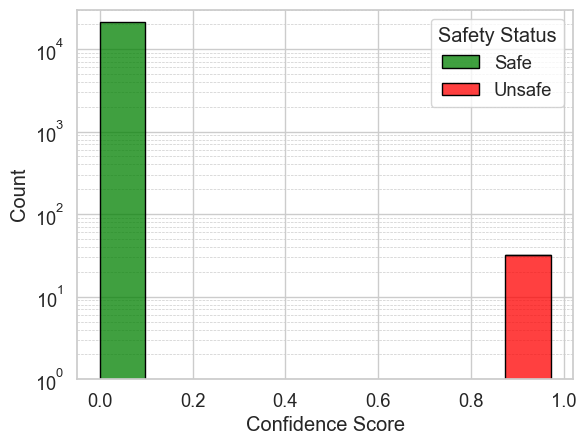

In [10]:
sns.set_theme(font_scale=1.2)
sns.set_style('whitegrid', {'grid.linestyle': '--'})

custom_color = {'Unsafe': 'red', 'Safe': 'green'}

ax = sns.histplot(data=result_df, x='prediction', hue='target', bins=10, multiple='stack', edgecolor='black', palette=custom_color)

plt.xlabel('Confidence Score')
plt.yscale('log')
plt.ylim(1, 30000)
ax.legend_.set_title('Safety Status')

plt.grid(True, which='major', linestyle='-', linewidth=1.0)
plt.grid(True, which='minor', linestyle='--', linewidth=0.5)

Best Threshold: 0.100
Best F1 Score: 1.0000


Text(0, 0.5, 'Score')

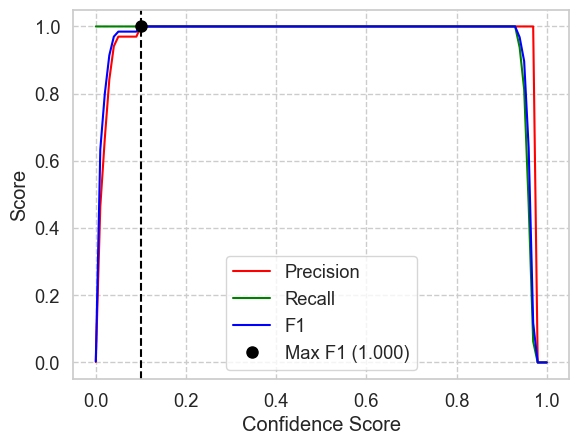

In [11]:
thr_val_arr = np.arange(0.0, 1.01, 0.01)

precision_arr = []
recall_arr = []
f1_arr = []

for thr_val in thr_val_arr:
    val_pred_binary = np.where(val_pred > thr_val, 1, 0)
    precision = precision_score(val_target, val_pred_binary, zero_division=0)
    recall = recall_score(val_target, val_pred_binary, zero_division=0)
    f1 = f1_score(val_target, val_pred_binary, zero_division=0)

    precision_arr.append(precision)
    recall_arr.append(recall)
    f1_arr.append(f1)

precision_arr = np.array(precision_arr)
recall_arr = np.array(recall_arr)
f1_arr = np.array(f1_arr)

sns.set_theme(font_scale=1.2)
sns.set_style('whitegrid', {'grid.linestyle': '--'})

sns.lineplot(x=thr_val_arr, y=precision_arr, color='red', label='Precision')
sns.lineplot(x=thr_val_arr, y=recall_arr, color='green', label='Recall')
sns.lineplot(x=thr_val_arr, y=f1_arr, color='blue', label='F1')

best_f1_index = np.argmax(f1_arr)

best_threshold = thr_val_arr[best_f1_index]
best_f1_score = f1_arr[best_f1_index]

print(f"Best Threshold: {best_threshold:.3f}")
print(f"Best F1 Score: {best_f1_score:.4f}")

plt.axvline(x=best_threshold, color='black', linestyle='--')

plt.plot(best_threshold, best_f1_score, 'o', color='black', markersize=8,
         markeredgecolor='black', label=f'Max F1 ({best_f1_score:.3f})')

plt.legend()

plt.xlabel('Confidence Score')
plt.ylabel('Score')

([<matplotlib.axis.YTick at 0x1d3331c4370>,
 [Text(0, 0.5, 'Safe(0)'), Text(0, 1.5, 'Unsafe(1)')])

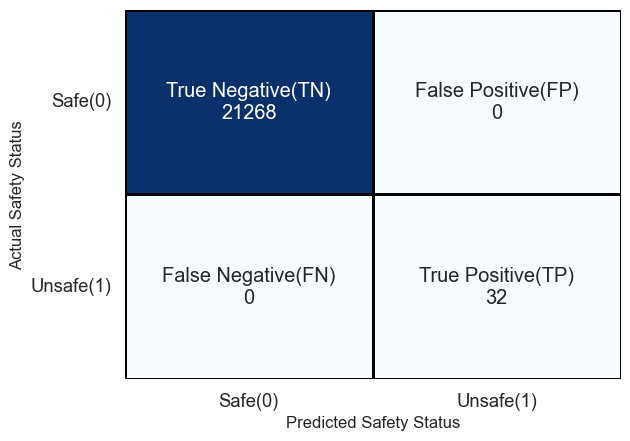

In [12]:
val_pred_binary = np.where(val_pred > best_threshold, 1, 0)

cm = confusion_matrix(val_target, val_pred_binary)

labels = np.array([[f'True Negative(TN)\n{cm[0, 0]}', f'False Positive(FP)\n{cm[0, 1]}'],
                   [f'False Negative(FN)\n{cm[1, 0]}', f'True Positive(TP)\n{cm[1, 1]}']])

sns.heatmap(cm, annot=labels, fmt='', cmap='Blues', cbar=False, linecolor='black', linewidths=1)

plt.ylabel('Actual Safety Status', fontsize=12)
plt.xlabel('Predicted Safety Status', fontsize=12)

plt.xticks([0.5, 1.5], ['Safe(0)', 'Unsafe(1)'])
plt.yticks([0.5, 1.5], ['Safe(0)', 'Unsafe(1)'], rotation=0, va='center')

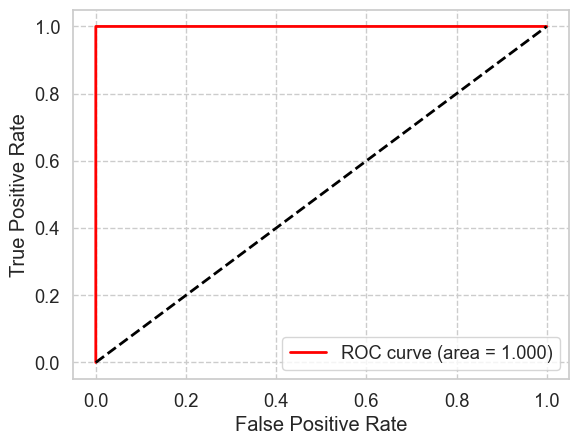

In [13]:
auc = roc_auc_score(y_true=val_target, y_score=val_pred)
fpr, tpr, thresholds = roc_curve(y_true=val_target, y_score=val_pred)

plt.plot(fpr, tpr, color='red', lw=2, label=f'ROC curve (area = {auc:.3f})')
plt.plot([0, 1], [0, 1], color='black', lw=2, linestyle='--') # 50% 수준의 랜덤 모델
#plt.xlim([0.0, 1.0])
#plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.grid(True)

In [14]:
dataset

,Time(sec),BUMA 1_1 CH=4,BUMA 1_2 CH=5,BUMA 1_3 CH=6,BUMA 2_1 CH=7,BUMA 2_2 CH=8,BUMA 2_3 CH=9,BUMA 3_1 CH=10,BUMA 3_2 CH=11,BUMA 3_3 CH=12,...,MX840B_CH 3 CH=152,MX840B_CH 4 CH=153,MX840B_CH 5 CH=154,MX840B_CH 6 CH=155,MX840B_CH 7 CH=156,MX840B_CH 8 CH=157\n,Work_Mode,Diff_Time(sec),Data_Type,Work_Load
0,0.000000,-3.678,-4.9400,-3.767,-1.9070,-0.08352,0.04852,-1.8750,-0.7639,-0.49290,...,-1000000.0,-1000000.0,-1000000.0,-1000000.0,-1000000.0,-1000000.0,pile_in,0.0,train,0.0
1,0.100000,-2.509,-3.6970,-2.093,-0.9704,0.48000,1.33100,-1.2170,-0.1403,-0.09153,...,-1000000.0,-1000000.0,-1000000.0,-1000000.0,-1000000.0,-1000000.0,pile_in,0.1,train,0.0
2,0.200000,-2.692,-3.5390,-2.516,-0.9318,0.96660,0.97150,-1.6220,-0.4432,0.09483,...,-1000000.0,-1000000.0,-1000000.0,-1000000.0,-1000000.0,-1000000.0,pile_in,0.1,train,0.0
3,0.300000,-3.185,-4.0320,-2.501,-0.8281,0.19600,1.03300,-1.3780,-0.5022,-0.01985,...,-1000000.0,-1000000.0,-1000000.0,-1000000.0,-1000000.0,-1000000.0,pile_in,0.1,train,0.0
4,0.400000,-2.455,-3.5990,-2.156,-0.8226,0.83630,0.98580,-1.3250,-0.5913,-0.07498,...,-1000000.0,-1000000.0,-1000000.0,-1000000.0,-1000000.0,-1000000.0,pile_in,0.1,train,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21369,275.800013,5.423,0.6258,5.743,0.3088,-2.86600,-7.25400,-1.0110,3.2680,-2.92500,...,-1000000.0,-1000000.0,-1000000.0,-1000000.0,-1000000.0,-1000000.0,pile_out,0.1,validation,0.0
21370,275.900013,5.708,0.8296,6.097,1.1680,-2.38400,-6.72400,-0.6484,3.1610,-3.02300,...,-1000000.0,-1000000.0,-1000000.0,-1000000.0,-1000000.0,-1000000.0,pile_out,0.1,validation,0.0
21371,276.000013,6.429,1.1600,6.845,1.1230,-2.06600,-6.96500,-0.1797,3.6360,-2.63700,...,-1000000.0,-1000000.0,-1000000.0,-1000000.0,-1000000.0,-1000000.0,pile_out,0.1,validation,0.0
21372,276.100013,6.606,1.8340,7.174,0.7554,-1.82100,-6.24600,-0.2944,3.9150,-2.03300,...,-1000000.0,-1000000.0,-1000000.0,-1000000.0,-1000000.0,-1000000.0,pile_out,0.1,validation,0.0
